**<h2 align="center">LOGISTIC REGRESSION</h2>** 

**<center> Synthetic Minority Oversampling Technique (SMOTE) is a statistical technique for increasing the number of cases in your dataset in a balanced way. The component works by generating new instances from existing minority cases that you supply as input. </center>**

### **Imports**

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, roc_auc_score
from sklearn.metrics import plot_confusion_matrix
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imbpipeline
from utils.data import load_file
from utils.metrics import evaluate
from sklearn.feature_extraction.text import CountVectorizer
import warnings 
warnings.filterwarnings('ignore')
from sklearn.preprocessing import StandardScaler

### **Load Data**

In [3]:
df = pd.read_csv("../data/review_2022_clean.csv")
df.head()

,text,label
0,bought fender telecaster salesperson told orig...,negative
1,visit son restaurant desert home food authenti...,positive
2,danielle great job listened cut hair way reque...,positive
3,saw lot roaches bathroom woke bed large dark s...,negative
4,ordered pork fried rice beef chow mei fun teri...,negative


### **Train-Test Split**

Create a function to perform train-test split.

In [4]:
df_sw = pd.read_csv("../data/review_2022_clean_sw.csv")
df_sw.head()

,text,label
0,i bought a fender telecaster that the salesper...,negative
1,this is our go to for take out when i visit my...,positive
2,danielle did a great job she listened and cut ...,positive
3,we saw a lot of roaches in the bathroom when w...,negative
4,we ordered pork fried rice and beef chow mei f...,negative


In [5]:
def split(stop_words=False):
  if stop_words:
    X = df_sw["text"]
    y = df_sw["label"]
  else:
    X = df["text"]
    y = df["label"]
  return train_test_split(X, y, test_size=0.2, random_state=42)

In [18]:
X_train, X_test, y_train, y_test = split()

In [19]:
X_train_sw, X_test_sw, y_train_sw, y_test_sw = split(stop_words=True)

### **Modeling**

Define parameter settings to try

In [25]:
C_range = np.logspace(-2, 2, 5)
C_range

array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02])

In [26]:
param_grid = {"logrec__C": C_range}

Create a function to create an instance of GridSearchCV.

In [35]:
def create_grid_search(ngram_range):
  tfidf = TfidfVectorizer(ngram_range=ngram_range)
  logrec = LogisticRegression(class_weight="balanced", random_state=42, max_iter=10000)
  pipe = imbpipeline(steps=[("tfidf", tfidf), ["smote", SMOTE(random_state=42)],  ("logrec", logrec)])
  
  search = GridSearchCV(pipe, param_grid, cv=10, scoring="balanced_accuracy", n_jobs=-1)
  return search

Create a function to perform training and evaluation.

In [33]:
def train_evaluate(ngram_range, X_train, X_test, y_train, y_test):
  search = create_grid_search(ngram_range)
  search.fit(X_train, y_train)

  print("Best Parameters:")
  print(search.best_params_)

  y_pred = search.predict(X_test)

  print("Classification Report:")
  print(classification_report(y_test, y_pred))

  print("Confusion Matrix:")
  ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
  plt.show()

  print("AUC Score:")
  print(roc_auc_score(y_test, search.predict_proba(X_test), average='weighted', multi_class='ovr'))

  return search

#### **Unigrams + Bigrams + Stop Words**

Best Parameters:
{'logrec__C': 1.0}
Classification Report:
              precision    recall  f1-score   support

    negative       0.88      0.89      0.88      1770
     neutral       0.41      0.43      0.42       428
    positive       0.95      0.94      0.95      4135

    accuracy                           0.89      6333
   macro avg       0.75      0.75      0.75      6333
weighted avg       0.89      0.89      0.89      6333

Confusion Matrix:


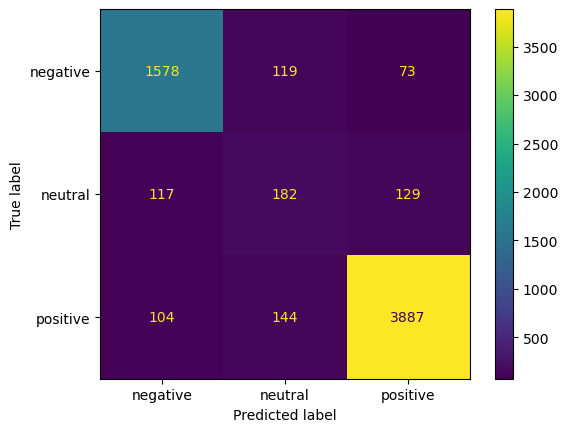

AUC Score:
0.9715420995930257


In [36]:
model_uni_bi_sw = train_evaluate((1, 2), X_train_sw, X_test_sw, y_train_sw, y_test_sw)